In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
from stl import mesh
import matplotlib.pyplot as plt

In [2]:
import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(fr'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [3]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]


In [4]:
a = 3.4
lambdas = np.array([8,1.5])/0.8

In [5]:
folder_path = rf"H:\phd stuff\tidy3d\structures\LSU H5\20250124"
project_name = "02_14_2025 Florescu LSU H5 Far Field Transmission"
postprocess_results = []
runtime_ps = 25e-12
min_steps_per_lambda = 20
cuts = [1]
for direction in ["z"]: 
    for f,filename in enumerate(os.listdir(folder_path)):
     for cut in cuts:
        if not (Path(filename).suffix==".h5" or Path(filename).suffix==".stl"):
            continue 

           
        if os.path.isfile(os.path.join(folder_path, filename)):
            file=os.path.join(folder_path, filename)
            structure_1 = AM.loadAndRunStructure(key = tidy3dAPI, file_path=file
                                            ,direction=direction, lambda_range=lambdas,
                                            box_size=14.3,runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda,
                                           scaling=1,shuoff_condtion=1e-20, verbose=True, 
                                           monitors=["flux"], 
                                           freqs=400, 
                                           cut_condition=cut, source="planewave", absorbers=120, use_permittivity=False,sim_name=rf"{Path(filename).stem}_size_{cut}"
                                           )
            
        
        file_desc = rf"H:\phd stuff\tidy3d\data\{project_name}_perm_{structure_1.permittivity_value}\z_incidence\{structure_1.sim_name}.txt"
        # if os.path.exists(file_desc):
        #     print("Exist!")
        # else:
        #    print("Creating...")
        #    structure_1.run_sim(run_free=False,load=False,add_ref=True,folder_description=rf"{project_name}_perm_{structure_1.permittivity_value}",monitor=True)

        # del structure_1

            
        # structure_1.plot_sim_layout()


Configured successfully.


<Figure size 1280x960 with 0 Axes>

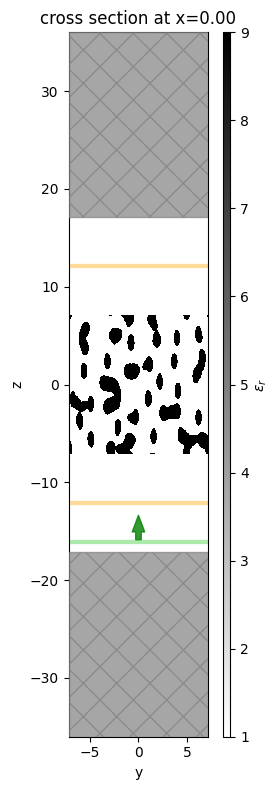

<Figure size 1600x1200 with 0 Axes>

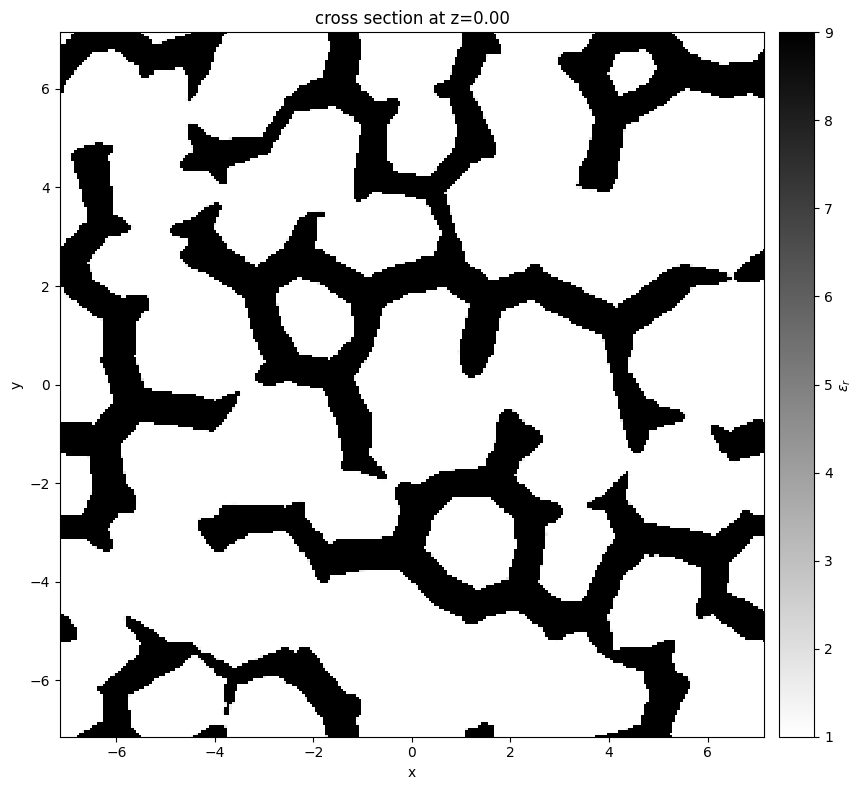

<Figure size 640x480 with 0 Axes>

In [6]:
structure_1.plot_sim_layout()

In [7]:
sim = structure_1.sim

In [8]:
#defining apertures 
# Define materials
air = td.Medium(permittivity=1)
pec = td.PECMedium()
# PEC plate thickness
thick = 1
width = 5
height = 5

# create the PEC plate
plate = td.Structure(
    geometry=td.Box(size=[td.inf, td.inf,thick], center=sim.monitors[1].center), medium=pec
)

# create the aperture in the plate
aperture = td.Structure(
    geometry=td.Box(size=[width, height,1.5 * thick], center=sim.monitors[1].center), medium=air
)

# make sure to append the aperture to the plate so that it overrides that region of the plate
geometry = structure_1.createSimObjects()["structures"]#+[plate,aperture]

In [9]:
# radial distance away from the origin at which to project fields
r_proj =  1e6

# theta and phi angles at which to observe fields - part of the half-space to the right
theta_proj = np.linspace(0, np.pi/2, 250)
phi_proj = np.linspace(0,2*np.pi, 250)

monitor_far = td.FieldProjectionAngleMonitor(
    center=sim.monitors[0].center,  # the monitor's center defined the local origin - the projection distance
    # and angles will all be measured with respect to this local origin
    size=[td.inf, td.inf,0],
    # the size and center of any far field monitor should indicate where the *near* fields are recorded
    freqs=structure_1.monitor_freqs,
    name="far_field",
    window_size= (0.25,0.25),
    normal_dir="+",
    phi=list(phi_proj),
    theta=list(theta_proj),
    proj_distance=r_proj,
    far_field_approx=True,  # we leave this to its default value of 'True' because we are interested in fields sufficiently
    # far away that geometric far field approximations can be invoked to speed up the calculation
)

In [10]:
sim = sim.copy(update={"structures":geometry, "monitors":[monitor_far]})


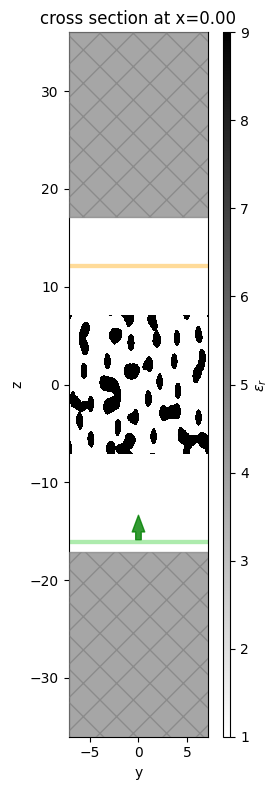

In [11]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
freqs_plot = (structure_1.freq_range[0], structure_1.freq_range[1])
sim.plot_eps(x=0, freq=freqs_plot[0], ax=ax)
plt.show()

In [12]:
run = False
if run:
        

        sim_data_0 = web.run(
            sim.copy(update={"structures":[]}), folder_name="20250227 Far Field LSU", task_name="20250227_far_field_test_complete_angles_0", verbose=False
            )
        
        sim_data = web.run(
            sim, task_name="0250227_far_field_test_complete_angles", verbose=False, folder_name="20250227 Far Field LSU",
            )
else: 
        file = rf"H:\phd stuff\tidy3d\data\20250227 Far Field LSU\0250227_far_field_test_complete_angles.txt"
        structure = AM.loadFromFile(key = tidy3dAPI, file_path=file,get_ref=True)
        sim_data, sim_data_0 = structure.sim_data, structure.sim_data0
        

    
      

Configured successfully.


13:39:45 W. Europe Standard Time Billed flex credit cost: 4.495.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

In [13]:
projected_field_data_0 = sim_data_0[monitor_far.name]
projected_field_data = sim_data[monitor_far.name]


In [14]:
indices = np.where(np.bool_(theta_proj*180/np.pi >=0) & np.bool_(theta_proj*180/np.pi <=10))[0]
indices_50_60 = np.where(np.bool_(theta_proj*180/np.pi >=50) & np.bool_(theta_proj*180/np.pi <=65))[0]

In [15]:
np.shape(projected_field_data_0.power) #(r,theta,phi,f)
np.shape(projected_field_data.power) #(r,theta,phi,f)

(1, 250, 250, 400)

In [16]:
r,theta,phi = r_proj,theta_proj[indices],phi_proj
theta_50_60 = theta_proj[indices_50_60]
# Calculate the differential surface area element in spherical coordinates
dA_1= (r ** 2) * np.sin(theta_proj) * np.diff(theta_proj)[0] * np.diff(phi)[0]

# Compute total power by summing over theta and phi
transmission_0 = ((projected_field_data_0.power.squeeze().values)* dA_1[:,np.newaxis,np.newaxis]).sum(axis=(0,1))

In [17]:
dA_2= (r ** 2) * np.sin(theta) * np.diff(theta)[0] * np.diff(phi)[0]
dA_3= (r ** 2) * np.sin(theta_50_60) * np.diff(theta_50_60)[0] * np.diff(phi)[0]


In [18]:
power_data = (projected_field_data.power.squeeze().values)
low_lambda_indices = np.where(structure_1.monitor_lambdas*0.8<=5.5)[0]
large_lambda_indices = np.where(structure_1.monitor_lambdas*0.8>5.5)[0]

In [19]:
np.shape(power_data[np.ix_(indices,np.arange(power_data.shape[1]),low_lambda_indices)])

(28, 250, 358)

In [20]:
transmission_low_lambda = (power_data[np.ix_(indices,np.arange(power_data.shape[1]),low_lambda_indices)]* dA_2[:,np.newaxis,np.newaxis]).sum(axis=(0,1))
transmission_low_lambda_50_60 = (power_data[np.ix_(indices_50_60,np.arange(power_data.shape[1]),low_lambda_indices)]* dA_3[:,np.newaxis,np.newaxis]).sum(axis=(0,1))
transmission_low = transmission_low_lambda+transmission_low_lambda_50_60
transmission_high_lambda = (power_data[:,:,large_lambda_indices]* dA_1[:,np.newaxis,np.newaxis]).sum(axis=(0,1))

# transmission = np.concatenate((transmission_high_lambda,transmission_low_lambda),axis=0)
transmission = np.concatenate((transmission_high_lambda,transmission_low),axis=0)

In [21]:
transmission_normalized = transmission/transmission_0

In [22]:
np.shape(transmission_normalized)

(400,)

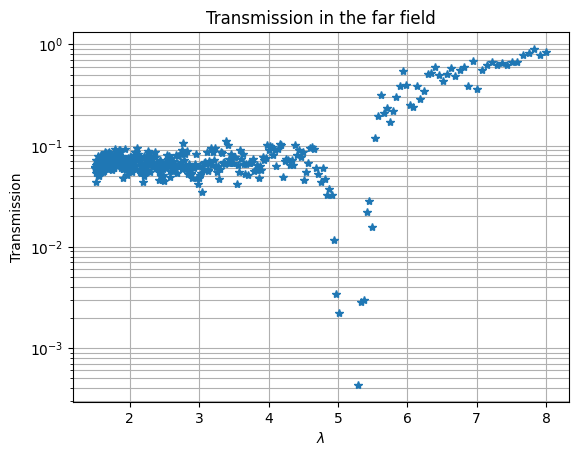

In [25]:
plt.plot(structure_1.monitor_lambdas*0.8,transmission_normalized,"*")
plt.yscale("log")
plt.ylabel("Transmission")
plt.xlabel(rf"$\lambda$")
# plt.ylim(1e-1,1)
plt.title("Transmission in the far field")
plt.grid(True, which="both")
plt.show()

In [26]:
data = {
                        'transmission_normalized':transmission_normalized,
                        'lambdas':structure_1.monitor_lambdas*0.8,
                  }
AM.create_hdf5_from_dict(data,"farfield 0-10.h5")